# Calibrating the GR4J-Cemaneige hydrological model using OSTRICH on the Raven server

Here we use birdy's WPS client to calibrate the GR4J-Cemaneige hydrological model on the server and analyze the calibrated parameter set and hydrograph. By default, Ostrich processes do not return the hydrograph, as writing the data to disk at each iteration takes considerable time. Data can be retrieved by setting the `suppress_output` parameter to False, or by running the model with the calibrated parameter set. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameter boundaries. Can either be a string of comma separated values, a list, an array or a named tuple. 
lowerBounds = '0.01, -15.0, 10.0, 0.0, 1.0, 0.0'
upperBounds = '2.5, 10.0, 700.0, 7.0, 30.0, 1.'
          
# Forcing files. This could be a simple path to a file. Here it is a PosixPAth so we convert to str later on.
ts=TESTDATA['ostrich-gr4j-cemaneige-nc-ts']

# OSTRICH configuration parameters
config = dict(
    algorithm='DDS',
    max_iterations=10,
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    lowerbounds=lowerBounds,
    upperbounds=upperBounds,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
    # Comment out the random seed to show different results!
    random_seed=6.67408*10**-11,
    )

# Let's call Ostrich with the timeseries, calibration parameters and other configuration parameters
resp = wps.ostrich_gr4j_cemaneige(ts=str(ts), **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[calibration, hydrograph, storage, solution, diagnostics, calibparams, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The diagnostics is just a CSV file storing the calibrated parameters. 

In [3]:
print(calibparams)

2.423961, 3.758972, 204.3856, 5.866946, 16.60408, 0.3728098


Now, let's run the model again using the same parameters and check to see that the NSE is the same. This will also give us access to the hydrograph estimated from the calibrated parameters. 

In [4]:
# Model configuration parameters
config = dict(area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
             )
# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_gr4j_cemaneige(ts=str(ts), params=calibparams, **config)
[hydrograph, storage, solution, diagnostics2, rv2] = resp.get(asobj=True)

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [5]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 209, nbasins: 1)>
array([[0.000000e+00],
       [2.348833e-02],
       [9.777275e-02],
       ...,
       [6.661886e+01],
       [6.718281e+01],
       [6.856098e+01]])
Coordinates:
  * time        (time) datetime64[ns] 1954-01-01 1954-01-02 ... 1954-07-28
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

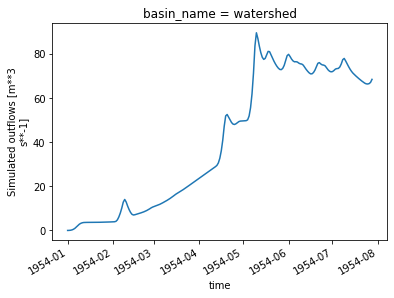

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

Now lets check to see if the diagnostics are the same.

In [7]:
print(diagnostics)
print(diagnostics2)

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_xdlo709v/Salmon-River-Near-Prince-George_meteo_daily.nc,0.486033,37.1449,

observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,
HYDROGRAPH,/tmp/pywps_process_szqq6q1v/Salmon-River-Near-Prince-George_meteo_daily.nc,0.486033,37.1449,

